### Plan
1. Get Image
2. Correct Distorsion
3. Grid
4. Detect

***

1. Get Image

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt 
from skimage import feature, measure

def get_image_from_camera(image_path: str):
    pass
    
# placeholder function
def get_image(image_path: str)-> np.ndarray:
    """
    Input: filepath of a PNG image
    Output: image as numpy array
    Example: get_image(os.path.join("..", "robot-env", "s1.png"))
    """
    try:
        img = cv2.imread(image_path) # BGR
        return img
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

img_name = "r2.jpg"
img = get_image(os.path.join("..", "robot-env", img_name))
print(img.shape, type(img[0][0][0]))

(1600, 1200, 3) <class 'numpy.uint8'>


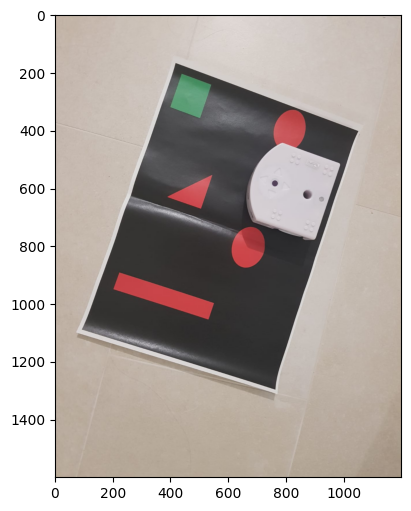

In [2]:
def show_cv2_img(img: np.ndarray, fig_size=(12,12), color="RGB", _axis=True, _title=None, _cmap=None):
    plt.figure(figsize=fig_size)
    if color == "BGR":
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap=_cmap) # BGR -> RGB
    else:
        plt.imshow(img, cmap=_cmap)
        
    if _title is not None:
        plt.title(_title)
    if not _axis:
        plt.axis('off')
    
    plt.show()

show_cv2_img(img, (6,6), "BGR")

2. Correct distorsion

- https://theailearner.com/tag/cv2-warpperspective/
- https://stackoverflow.com/questions/22656698/perspective-correction-in-opencv-using-python
- https://discorpy.readthedocs.io/en/latest/tutorials/methods.html
- https://pyimagesearch.com/2021/10/06/opencv-contour-approximation/
- https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html
- https://www.geeksforgeeks.org/convex-hull-algorithm/
- https://stackoverflow.com/questions/47540926/get-the-largest-connected-component-of-segmentation-image
- https://scikit-image.org/docs/stable/auto_examples/edges/plot_canny.html
- https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html

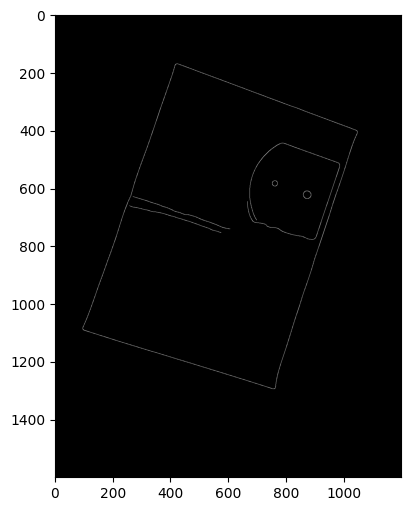

In [3]:
edges = feature.canny(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), sigma=5)
show_cv2_img(edges, (6,6), _cmap="gray")

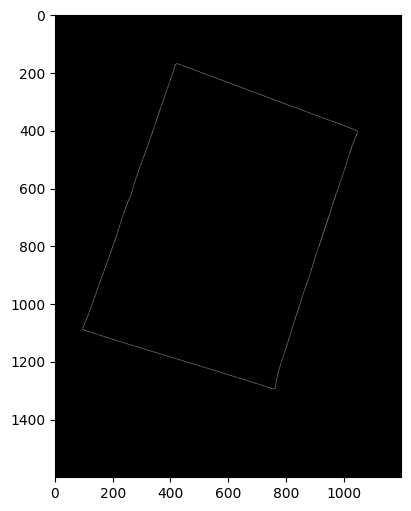

In [4]:
# largest connected component
def lcc(edges: np.ndarray)->np.ndarray:
    labels = measure.label(edges)
    counts = np.bincount(labels.ravel())
    counts[0] = 0 # disregard background
    largest_label = counts.argmax()
    mask = labels == largest_label
    return mask

lcc_mask = lcc(edges)
outer_edge = np.zeros_like(edges) # for visualization, no need for production
outer_edge[lcc_mask] = 1

show_cv2_img(outer_edge, (6,6), _cmap="gray")

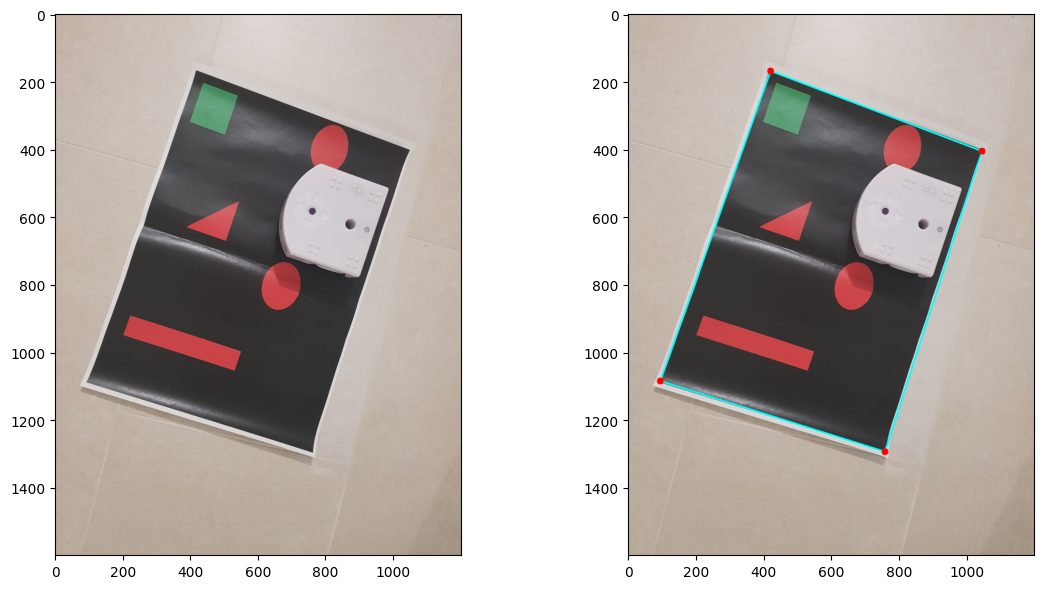

In [5]:
def find_corners(lcc_mask: np.ndarray, epsilon = 0.01)->np.ndarray: 
    contours, hierarchy = cv2.findContours((lcc_mask * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    
    approx = cv2.approxPolyDP(largest_contour, epsilon * cv2.arcLength(largest_contour, True), True)
    
    if len(approx) == 4:
        corners = approx.reshape(4, 2)
    else:
        while len(approx) != 4:
            epsilon = epsilon + 0.001
            approx = cv2.approxPolyDP(largest_contour, epsilon * cv2.arcLength(largest_contour, True), True)
        corners = approx.reshape(-1, 2)

    return corners, approx

corners, approx = find_corners(lcc_mask)

# visualization
img_corners = img.copy()
cv2.drawContours(img_corners, [approx], -1, (255, 255, 0), 3)
for corner in corners:
    cv2.circle(img_corners, tuple(corner), 10, (0, 0, 255), -1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_corners, cv2.COLOR_BGR2RGB))
plt.tight_layout()
plt.show()

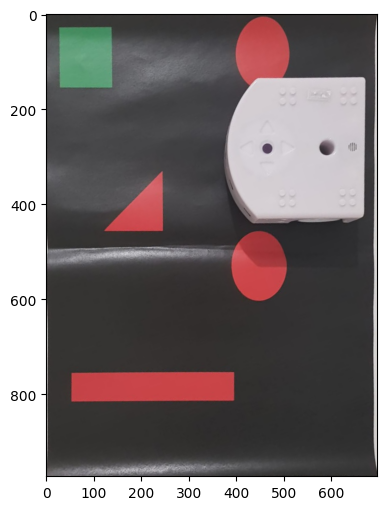

In [6]:
def order_points(pts):
    """
    Orders points in the following order:
    [top-left, top-right, bottom-right, bottom-left]
    """
    rect = np.zeros((4, 2), dtype="float32")
    
    # Sum and difference
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)
    
    # Top-left point will have the smallest sum
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum
    rect[2] = pts[np.argmax(s)]
    # Top-right point will have the smallest difference
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left point will have the largest difference
    rect[3] = pts[np.argmax(diff)]
    
    return rect


ordered_corners = order_points(corners)

# Define the dimensions of the new image (e.g., width and height)
# Compute the width and height of the new image based on the distances between points
def compute_destination_size(ordered_pts):
    (tl, tr, br, bl) = ordered_pts

    # Compute the width of the new image
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))

    # Compute the height of the new image
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))

    return maxWidth, maxHeight

maxWidth, maxHeight = compute_destination_size(ordered_corners)

# Define destination points to obtain a "birds eye view"
dst = np.array([
    [0, 0],
    [maxWidth - 1, 0],
    [maxWidth - 1, maxHeight - 1],
    [0, maxHeight - 1]], dtype="float32")

# Compute the perspective transform matrix
M = cv2.getPerspectiveTransform(ordered_corners, dst)

# Apply the perspective transformation
warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)

show_cv2_img(warped, (6,6), "BGR")

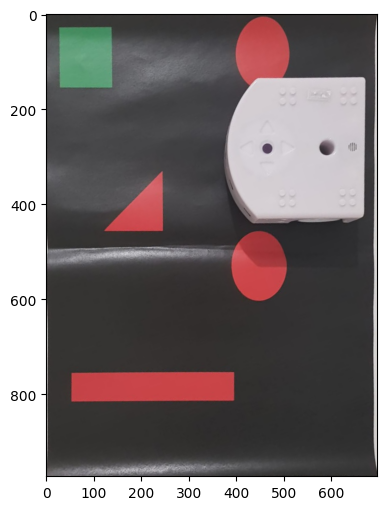

In [7]:
pt_A = corners[0]
pt_B = corners[1]
pt_C = corners[2]
pt_D = corners[3]
width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
maxWidth = max(int(width_AD), int(width_BC))
 
 
height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
maxHeight = max(int(height_AB), int(height_CD))


input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
output_pts = np.float32([[0, 0],
                        [0, maxHeight - 1],
                        [maxWidth - 1, maxHeight - 1],
                        [maxWidth - 1, 0]])

M = cv2.getPerspectiveTransform(input_pts,output_pts)
out = cv2.warpPerspective(img,M,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR)

show_cv2_img(out, (6,6), "BGR")

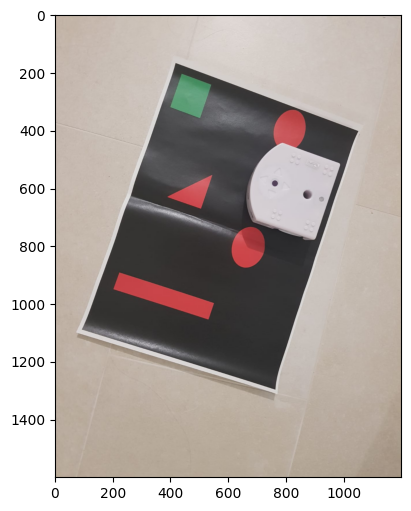

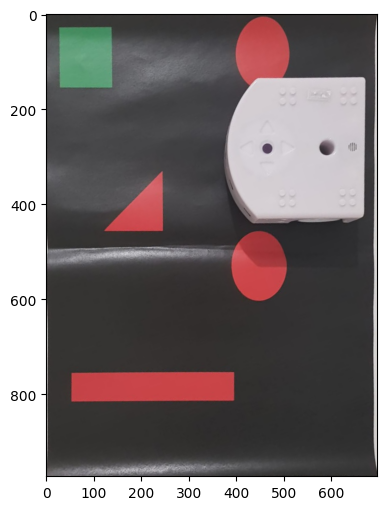

In [8]:
def correct_distorsion(img: np.ndarray) -> np.ndarray:
    edges = feature.canny(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), sigma=5)
    lcc_mask = lcc(edges)
    corners, _ = find_corners(lcc_mask)
    return corners

def crop_image(img: np.ndarray, corners: np.ndarray) -> np.ndarray:
    ordered_corners = order_points(corners)
    maxWidth, maxHeight = compute_destination_size(ordered_corners)
    M = cv2.getPerspectiveTransform(ordered_corners, dst)
    warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)
    return warped

corners = correct_distorsion(img)
img = crop_image(img, corners)
show_cv2_img(img, (6,6), "BGR")

3. Grid

In [9]:
T_R = 150
T_W = 200
def threshold_image(img: np.ndarray) -> np.ndarray:
    # if (r,g,b) > (T_W,T_W,T_W) then white
    # if (r,g,b) > (T_R,0,0) then red
    # else black
    thresholded_img = np.zeros_like(img)

    white_mask = (img[:, :, 0] > T_W) & (img[:, :, 1] > T_W) & (img[:, :, 2] > T_W)
    thresholded_img[white_mask] = [255, 255, 255]

    #red_mask = (img[:, :, 0] > T_R) & (img[:, :, 1] < 50) & (img[:, :, 2] < 50)
    red_mask = img[:, :, 0] > T_R
    thresholded_img[red_mask] = [255, 0, 0]

    black_mask = ~(white_mask | red_mask)
    thresholded_img[black_mask] = [0, 0, 0]


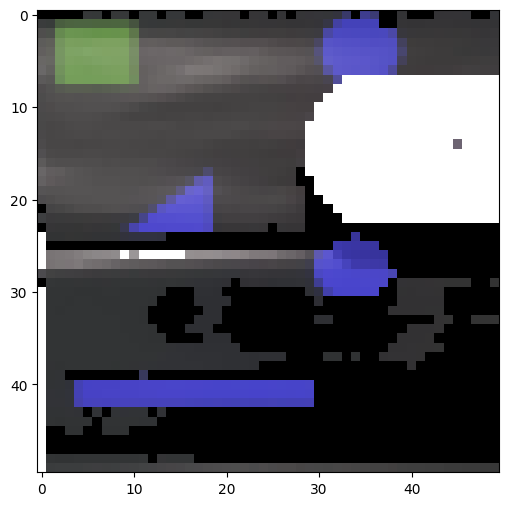

In [10]:
def get_dominant_color(block):
    """
    Determine the dominant color in the block based on priority:
    White > Red > Black. Returns the dominant color.
    """
    # Flatten the block to a list of pixels
    pixels = block.reshape(-1, 3)

    # Define color thresholds
    white_thresh = [200, 200, 200]   # Anything brighter is considered white
    red_thresh = [150, 0, 0]         # Pixels with high red channel and low green/blue are considered red
    black_thresh = [50, 50, 50]      # Anything darker is considered black

    has_white = np.any((pixels >= white_thresh).all(axis=1))
    has_red = np.any((pixels[:, 2] < 50) & (pixels[:, 1] < 50) & (pixels[:, 0] > red_thresh[0]))
    has_black = np.any((pixels <= black_thresh).all(axis=1))

    # Priority: White > Red > Black
    if has_white:
        return [255, 255, 255]  # White
    elif has_red:
        return [0, 0, 255]      # Red (OpenCV uses BGR format)
    elif has_black:
        return [0, 0, 0]        # Black
    else:
        # If no dominant color, return average color
        return block.mean(axis=(0, 1)).astype(int)


def discretize_image(img, grid_size):
    """
    Discretizes an OpenCV image using a grid of grid_size x grid_size cells.
    """
    height, width, _ = img.shape
    cell_height = height // grid_size
    cell_width = width // grid_size

    # Initialize the grid image and discretized image
    grid_image = np.zeros((grid_size, grid_size, 3), dtype=np.uint8)
    discretized_image = np.copy(img)

    # Loop over each cell in the grid
    for i in range(grid_size):
        for j in range(grid_size):
            # Calculate the block boundaries
            start_y = i * cell_height
            end_y = (i + 1) * cell_height
            start_x = j * cell_width
            end_x = (j + 1) * cell_width

            # Extract the block from the original image
            block = img[start_y:end_y, start_x:end_x]

            # Get the dominant color for the block
            dominant_color = get_dominant_color(block)

            # Check for collision detection
            if np.any((block.reshape(-1, 3) >= [200, 200, 200]).all(axis=1)) and \
               np.any((block.reshape(-1, 3)[:, 2] < 50) & (block.reshape(-1, 3)[:, 1] < 50) & (block.reshape(-1, 3)[:, 0] > 150)):
                print("COLLISION DETECTED in block ({}, {})".format(i, j))

            # Assign the dominant color to the grid image
            grid_image[i, j] = dominant_color

            # Reassign all pixels in the discretized image block to the dominant color
            discretized_image[start_y:end_y, start_x:end_x] = dominant_color

    return grid_image, discretized_image


grid_size = 50
grid_image, discretized_img = discretize_image(img, grid_size)
show_cv2_img(grid_image, (6,6))

4. Detect